### Importing necessary modules, setting parameters and paths

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from scipy import optimize
import time
import os
import os.path
import zipfile
import pandas as pd
from scipy.optimize import curve_fit, least_squares
import sys
import gmsh
import math

import matplotlib.image as mpimg
import re

import pyvista as pv
import ipywidgets as widgets
from IPython.display import display, Image
pv.set_plot_theme("document")

plt.rcParams['figure.figsize'] = [12, 9]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = "Serif"
plt.rcParams['font.size'] = 20

from pyvirtualdisplay import Display
display = Display(backend="xvfb", visible=False, size=(1024, 768))
display.start()
    
user_name=!whoami # get user name
user_name=user_name[0]
um_view = "/mofem_install/jupyter/%s/um_view" % user_name

### Define utility functions (mesh generation, running the analysis, results post-processing)

In [2]:
# Defining a dictionary to contain variables
class AttrDict(dict):
    def __getattr__(self, attr):
        if attr in self:
            return self[attr]
        raise AttributeError(f"'AttrDict' object has no attribute '{attr}'")

        
# Post-processing for extraction of results variables from text file 
def parse_log_file(params):
    res = AttrDict()
    with open("log", "r") as log_file:
        for line in log_file:
            line = line.strip()
            if "nb global dofs" in line:
                res.elem_num = int(line.split()[13])
            if "error L2 norm" in line:
                res.err_l2_norm = float(line.split()[7])
            if "error H1 seminorm" in line:
                res.err_h1_snorm = float(line.split()[7])
            if "error indicator" in line:
                res.err_indic_tot = float(line.split()[6])
    return res


# Generation of a config file - what attributes should the blocksets have
def generate_config(params):
    # Open the file for writing
    with open(params.config_file, 'w') as f:
        # FIX_ALL boundary condition (do not change)
        data = ['[SET_ATTR_FIX_ALL]', 'number_of_attributes=3', 'user1=0', 'user2=0', 'user3=0']
        # Use a for loop to write each line of data to the file
        for line in data:
            f.write(line + '\n')
            # print the data as it is written to the file
            print(line)
        # FIX_Y_0 boundary condition 
        data = ['[SET_ATTR_FIX_Y_0]', 'number_of_attributes=3', 'user1=0', 'user2=0', 'user3=0']
        for line in data:
            f.write(line + '\n')
        # print the data as it is written to the file
            print(line)
        # FIX_X_0 boundary condition
        data = ['[SET_ATTR_FIX_X_0]', 'number_of_attributes=3', 'user1=0', 'user2=0', 'user3=0']
        for line in data:
            f.write(line + '\n')
        # print the data as it is written to the file
            print(line)
        # FIX_Z_0 boundary condition
        data = ['[SET_ATTR_FIX_Z_0]', 'number_of_attributes=3', 'user1=0', 'user2=0', 'user3=0']
        for line in data:
            f.write(line + '\n')
        # print the data as it is written to the file
            print(line)
        # FIX_X_1 boundary condition where displacement is applied
        data = ['[SET_ATTR_FIX_X_1]', 'number_of_attributes=3', 'user1='+str(params.disp_x), 
                'user2='+str(params.disp_y), 'user3='+str(params.disp_z)]
        # Use a for loop to write each line of data to the file
        for line in data:
            f.write(line + '\n')
            # print the data as it is written to the file
            print(line)
        # Elastic analysis for pile 
        data = ['[SET_ATTR_MAT_ELASTIC_CYLINDER]', 'number_of_attributes=2', 'user1='+str(params.elastic_youngs_modulus_cylinder), 
                'user2='+str(params.elastic_poisson_ratio_cylinder)]
        for line in data:
            f.write(line + '\n')
            # print the data as it is written to the file
            print(line)
        # Elastic analysis for soil
        data = ['[SET_ATTR_MAT_ELASTIC_SOIL]', 'number_of_attributes=2', 'user1='+str(params.elastic_youngs_modulus_soil), 
                'user2='+str(params.elastic_poisson_ratio_soil)]
        for line in data:
            f.write(line + '\n')
            # print the data as it is written to the file
            print(line)

            
# Generate mesh
def generate_mesh(params):
    
    # Initialize gmsh
    gmsh.initialize()
    gmsh.option.setNumber("General.Verbosity", 3)

    # Translation of .geo file 
    box1 = gmsh.model.occ.addBox(-80, -80, 0, 160, 160, 40) # Soil domain
    cylinder1 = gmsh.model.occ.addCylinder(0, 0, -10, 0, 0, 20.5, 1, -1, 2*math.pi) # Two metre diameter pile
    cylinder2 = gmsh.model.occ.addCylinder(0, 0, -10, 0, 0, 20.5, 0.975, -1, 2*math.pi) # Inner pile needed to hollow out
    box2 = gmsh.model.occ.addBox(-40, -40, 0, 80, 80, 20) # Area of refined mesh
    box3 = gmsh.model.occ.addBox(-20, -20, 0, 40, 40, 15) # Area of further refined mesh
    box4 = gmsh.model.occ.addBox(-200, 0, -200, 400, 400, 400) # Box for cutting domain in half
    
    gmsh.model.occ.cut([[3, 1], [3, 2], [3, 4], [3, 5]], [[3, 6], [3, 3]], -1, True, True) # Cut soil domain with inner cylinder and then in half
    gmsh.model.occ.fragment([[3, 4], [3, 5], [3, 3], [3, 2], [3, 1]], [], -1, True, False)
       
    # Create the relevant Gmsh data structures from Gmsh model.
    gmsh.model.occ.synchronize()
    
    
    # DISCRETISATION
    # PILE
    # Transfinite curves around pile - HEIGHTS
    for n in [40, 52, 48, 44, 56, 53, 60, 55]:
        gmsh.model.mesh.setTransfiniteCurve(n, 120,'Progression', 1.0)
            
    # Transfinite curves around pile - CIRLCES
    for n in [51, 45, 59, 54, 47, 46]:
        gmsh.model.mesh.setTransfiniteCurve(n, 60,'Progression', 1.0)
            
    # Transfinite curves around pile - BASE
    for n in [42]:
        gmsh.model.mesh.setTransfiniteCurve(n, 60,'Progression', 1.0)  
            
    # Transfinite curves around pile BELOW MUDLINE- THICKNESS 
    for n in [50, 49, 43, 41]:
        gmsh.model.mesh.setTransfiniteCurve(n, 1,'Progression', 1.0)  
        
    # Transfinite curves around pile ABOVE MUDLINE - THICKNESS
    for n in [58, 57]:
        gmsh.model.mesh.setTransfiniteCurve(n, 1,'Progression', 1.0)  
            
    # Transfinite surface around thickness
    for n in [22, 24, 29, 27, 30, 26, 19, 25, 23, 20]:
        gmsh.model.mesh.setTransfiniteSurface(n, 'Left')
    
    # Transfinite volume for pile
    for n in [4]:
        gmsh.model.mesh.setTransfiniteVolume(n)
    
    
    # SOIL DOMAIN 
    # Transfinite curves around soil domain - HEIGHTS
    for n in [2, 4, 9, 19]:
        gmsh.model.mesh.setTransfiniteCurve(n, 30,'Progression', 1.0)
    
    # Transfinite curves around soil domain - WIDTH
    for n in [6, 1, 17, 3]:
        gmsh.model.mesh.setTransfiniteCurve(n, 30,'Progression', 1.0)
       
    # Transfinite curves around soil domain - LONG LENGTHS
    for n in [5, 7, 18]:
        gmsh.model.mesh.setTransfiniteCurve(n, 60,'Progression', 1.0)
    
    # Transfinite curves around soil domain - SHORT LENGTHS
    for n in [8, 10]:
        gmsh.model.mesh.setTransfiniteCurve(n, 30,'Progression', 1.0)
        
        
    # BIG REFINEMENT BOX
    # Transfinite curves around refinement box - HEIGHTS
    for n in [13, 11, 21, 24]:
        gmsh.model.mesh.setTransfiniteCurve(n, 30,'Progression', 1.0)
    
    # Transfinite curves around refinement box - WIDTH
    for n in [20, 22, 16, 14]:
        gmsh.model.mesh.setTransfiniteCurve(n, 30,'Progression', 1.0)
       
    # Transfinite curves around refinement box - LONG LENGTHS
    for n in [12, 15, 23]:
        gmsh.model.mesh.setTransfiniteCurve(n, 60,'Progression', 1.0)
    
    # Transfinite curves around refinement box - SHORT LENGTHS
    for n in [25, 26]:
        gmsh.model.mesh.setTransfiniteCurve(n, 30,'Progression', 1.0)    
    
    
    # SMALL REFINEMENT BOX
    # Transfinite curves around refinement box - HEIGHTS
    for n in [27, 34, 37, 29]:
        gmsh.model.mesh.setTransfiniteCurve(n, 30,'Progression', 1.0)
    
    # Transfinite curves around refinement box - WIDTH
    for n in [35, 33, 30, 32]:
        gmsh.model.mesh.setTransfiniteCurve(n, 30,'Progression', 1.0)
       
    # Transfinite curves around refinement box - LONG LENGTHS
    for n in [28, 36, 31]:
        gmsh.model.mesh.setTransfiniteCurve(n, 60,'Progression', 1.0)
    
    # Transfinite curves around refinement box - SHORT LENGTHS LHS
    for n in [39]:
        gmsh.model.mesh.setTransfiniteCurve(n, 30,'Progression', 1.0)
    
    # Transfinite curves around refinement box - SHORT LENGTHS RHS
    for n in [38]:
        gmsh.model.mesh.setTransfiniteCurve(n, 30,'Progression', 1.0)  
    
    print(gmsh.model.getEntities(3))
    

# gmsh.model.addPhysicalGroup(dimention, [number of element], name="name")
    gmsh.model.addPhysicalGroup(3, [1,2,3,4,5], name="MAT_ELASTIC_")
    gmsh.model.addPhysicalGroup(3, [1, 2, 3], name="SOIL") # Volume of soil domain
    gmsh.model.addPhysicalGroup(3, [4, 5], name="CYLINDER") # Volume of pile
    gmsh.model.addPhysicalGroup(2, [1], name="FIX_ALL") # Boundary condition on plane
    gmsh.model.addPhysicalGroup(2, [29, 27, 24, 22, 17, 11, 3, 5], name="FIX_Y_0") # Boundary condition on plane
    gmsh.model.addPhysicalGroup(2, [6], name="FIX_X_0") # Boundary condition on plane
    gmsh.model.addPhysicalGroup(2, [2], name="FIX_Z_0") # Boundary condition on plane
    gmsh.model.addPhysicalGroup(2, [28], name="FIX_X_1") # Prescribed displacement on plane

    # Generate a 3D mesh
    gmsh.model.mesh.generate(3)
    
    # Save as a .med file
    med_file = params.mesh_file + ".med"
    gmsh.write(med_file)
    
    # Close gmsh
    gmsh.finalize()
    
    # Translate .med file to a format readable by MoFEM and assign values to physical groups
    h5m_file=params.mesh_file + ".h5m"    
    !read_med -med_file {med_file} -output_file {h5m_file} -meshsets_config {params.config_file} -log_sl error
    
    # Visualise the mesh
    if params.show_mesh:
        vtk_file=params.mesh_file + ".vtk"
        !mbconvert {h5m_file} {vtk_file}

        mesh = pv.read(vtk_file)
        mesh = mesh.shrink(0.98)

        p = pv.Plotter(notebook=True)
        p.add_mesh(mesh, smooth_shading=False)

        p.camera_position = "xy"
        p.show(jupyter_backend='ipygany')
    
    return

            
# Function for running MoFEM
def run_mofem(params):
        
# Find and partition mesh
    params.part_file = params.mesh_file + "_" + str(params.nproc) + "p.h5m"

# Run MoFEM on multiple processors. Everything is already defined so calls all the variables.    
    !rm -rf {params.show_file}*
    !{um_view}/bin/mofem_part -my_file {params.mesh_file}".h5m" -output_file {params.part_file} \
    -my_nparts {params.nproc}
    
    
# Run the chosen MoFEM executable
# Contains some plasticity parameters but there are not required for analysis
    !export OMPI_MCA_btl_vader_single_copy_mechanism=none && \
    nice -n 10 mpirun --oversubscribe --allow-run-as-root \
    -np {params.nproc} {um_view}/tutorials/vec-0/{params.executable} \
    -file_name {params.part_file} -time_vector_file {params.bc_time_history}.txt \
    -yield_stress {params.yield_stress} \
    -hardening {params.hardening} \
    -Qinf {params.Qinf} -b_iso {params.b_iso} \
    -large_strains {params.large_strains} \
    -ts_dt {params.ts_dt} \
    -ts_max_time {params.ts_max_time} \
    -ts_type {params.ts_type} \
    -snes_linesearch_type {params.snes_linesearch_type} \
    -order {params.order} \
    -scale 1 \
    -post_proc_skin_only 1\
    -cn {params.cn} 2>&1 | tee {params.log_file}
    # -young_modulus {params.young_modulus} \
    # -poisson_ratio {params.poisson_ratio} \ want to read these from block set
    # Tells to print everything 
    # convert results to vtk if desired
    !convert.py -np {params.nproc} out*
    
    # return results found by parse_log_file
    return parse_log_file(params)



### Dictionary defining all relevant parameters for solving the problem

In [3]:
# Attribute dictionary for storing the parameters i.e. params is going to have variables in it.
params = AttrDict()

# Pre-processing parameters
params.mesh_file = "necking_test" # no file extension needed
params.bc_time_history = "disp_time" # no file extension needed

# Pre-processing parameters. Anything that is called in gmsh function should be defined here.
params.mesh_file = "beam_box"
#params.length_x = 10
#params.length_y = 1
#params.length_z = 1
#params.element_size = 0.3 # element size in the regular mesh
params.show_mesh = True

# Boundary condition. Parameters called by the config file function. 
params.config_file = "bc.cfg"
params.disp_x = 1. #metres
params.disp_y = 0.
params.disp_z = 0.

# Constitutive model parameters for pile
params.elastic_youngs_modulus_cylinder = 200 *(10 **9) #Pa
params.elastic_poisson_ratio_cylinder = 0.3

# Constitutive model parameters for soil
params.elastic_youngs_modulus_soil = 392 *(10 **6) #Pa 
params.elastic_poisson_ratio_soil = 0.499
params.log_file = 'log_meshSSFINAL'

# Plasticity parameters that were not required
#params.poisson_ratio = (3.*bulk_modulus-2.*shear_modulus)/(2.*shear_modulus+6.*bulk_modulus) # MPa
#params.young_modulus = 2.*shear_modulus*(1.+params.poisson_ratio) # MPa
params.yield_stress = 0.45e3 # MPa
params.hardening = 0.12924e3 # MPa
params.Qinf = 265 # MPa
params.b_iso = 16.93
params.cn = 1 # Stability parameter

# Solution parameters
params.executable = "elastic_3d" # Executable name
params.nproc = 12 # Number of processors
params.ts_dt = 0.015 # Time step size
params.ts_max_time = 1.0 # End time of simulation
params.ts_type = "theta" # Time integration scheme
params.snes_linesearch_type = "l2" 
params.order = 2 # Approximation order. Defining linear or quadratic shape functions
params.large_strains = 1 # 1 - large strains, 0 - small strains

# Post-processing parameters
params.show_file = "out" # Output file name. No extension needed.

### Generate a mesh 

In [4]:
params.show_mesh = False
generate_config(params)
generate_mesh(params)

[SET_ATTR_FIX_ALL]
number_of_attributes=3
user1=0
user2=0
user3=0
[SET_ATTR_FIX_Y_0]
number_of_attributes=3
user1=0
user2=0
user3=0
[SET_ATTR_FIX_X_0]
number_of_attributes=3
user1=0
user2=0
user3=0
[SET_ATTR_FIX_Z_0]
number_of_attributes=3
user1=0
user2=0
user3=0
[SET_ATTR_FIX_X_1]
number_of_attributes=3
user1=0.5
user2=0.0
user3=0.0
[SET_ATTR_MAT_ELASTIC_CYLINDER]
number_of_attributes=2
user1=200000000000
user2=0.3
[SET_ATTR_MAT_ELASTIC_SOIL]
number_of_attributes=2
user1=392000000
user2=0.499
[(3, 1), (3, 2), (3, 3), (3, 4), (3, 5)]


In [5]:
run_mofem(params)

[0] <inform> MoFEM version 0.14.0 (MOAB 5.3.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 6e906def6b7b259c357095aa027ae2a12bd934cf
[0] <inform> Local time: 2024-1-11 23:21:59
[0] <inform> UTC time: 2024-1-11 23:21:59
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316737 type BLOCKSET UNKNOWNNAME msId 1 name untitled
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 2 name                                
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 3 name FIX_ALL
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316740 type BLOCKSET UNKNOWNNAME msId 4 name FIX_X_0
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316741 type BLOCKSET UNKNOWNNAME msId 5 name FIX_X_1
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316742 type BLOCKSET UNKNOWNNAME msId 6 name FIX_Y_0
[0] 

{}

### Convergence Analysis - Effect of Progression

[34542, 88614, 195651, 328902, 563175, 828105, 1239579, 1635801]
[5755000.0, 5695000.0, 5680000.0, 5660000.0, 5645000.0, 5645000.0, 5640000.0, 5640000.0]
[11510000.0, 11390000.0, 11360000.0, 11320000.0, 11290000.0, 11290000.0, 11280000.0, 11280000.0]


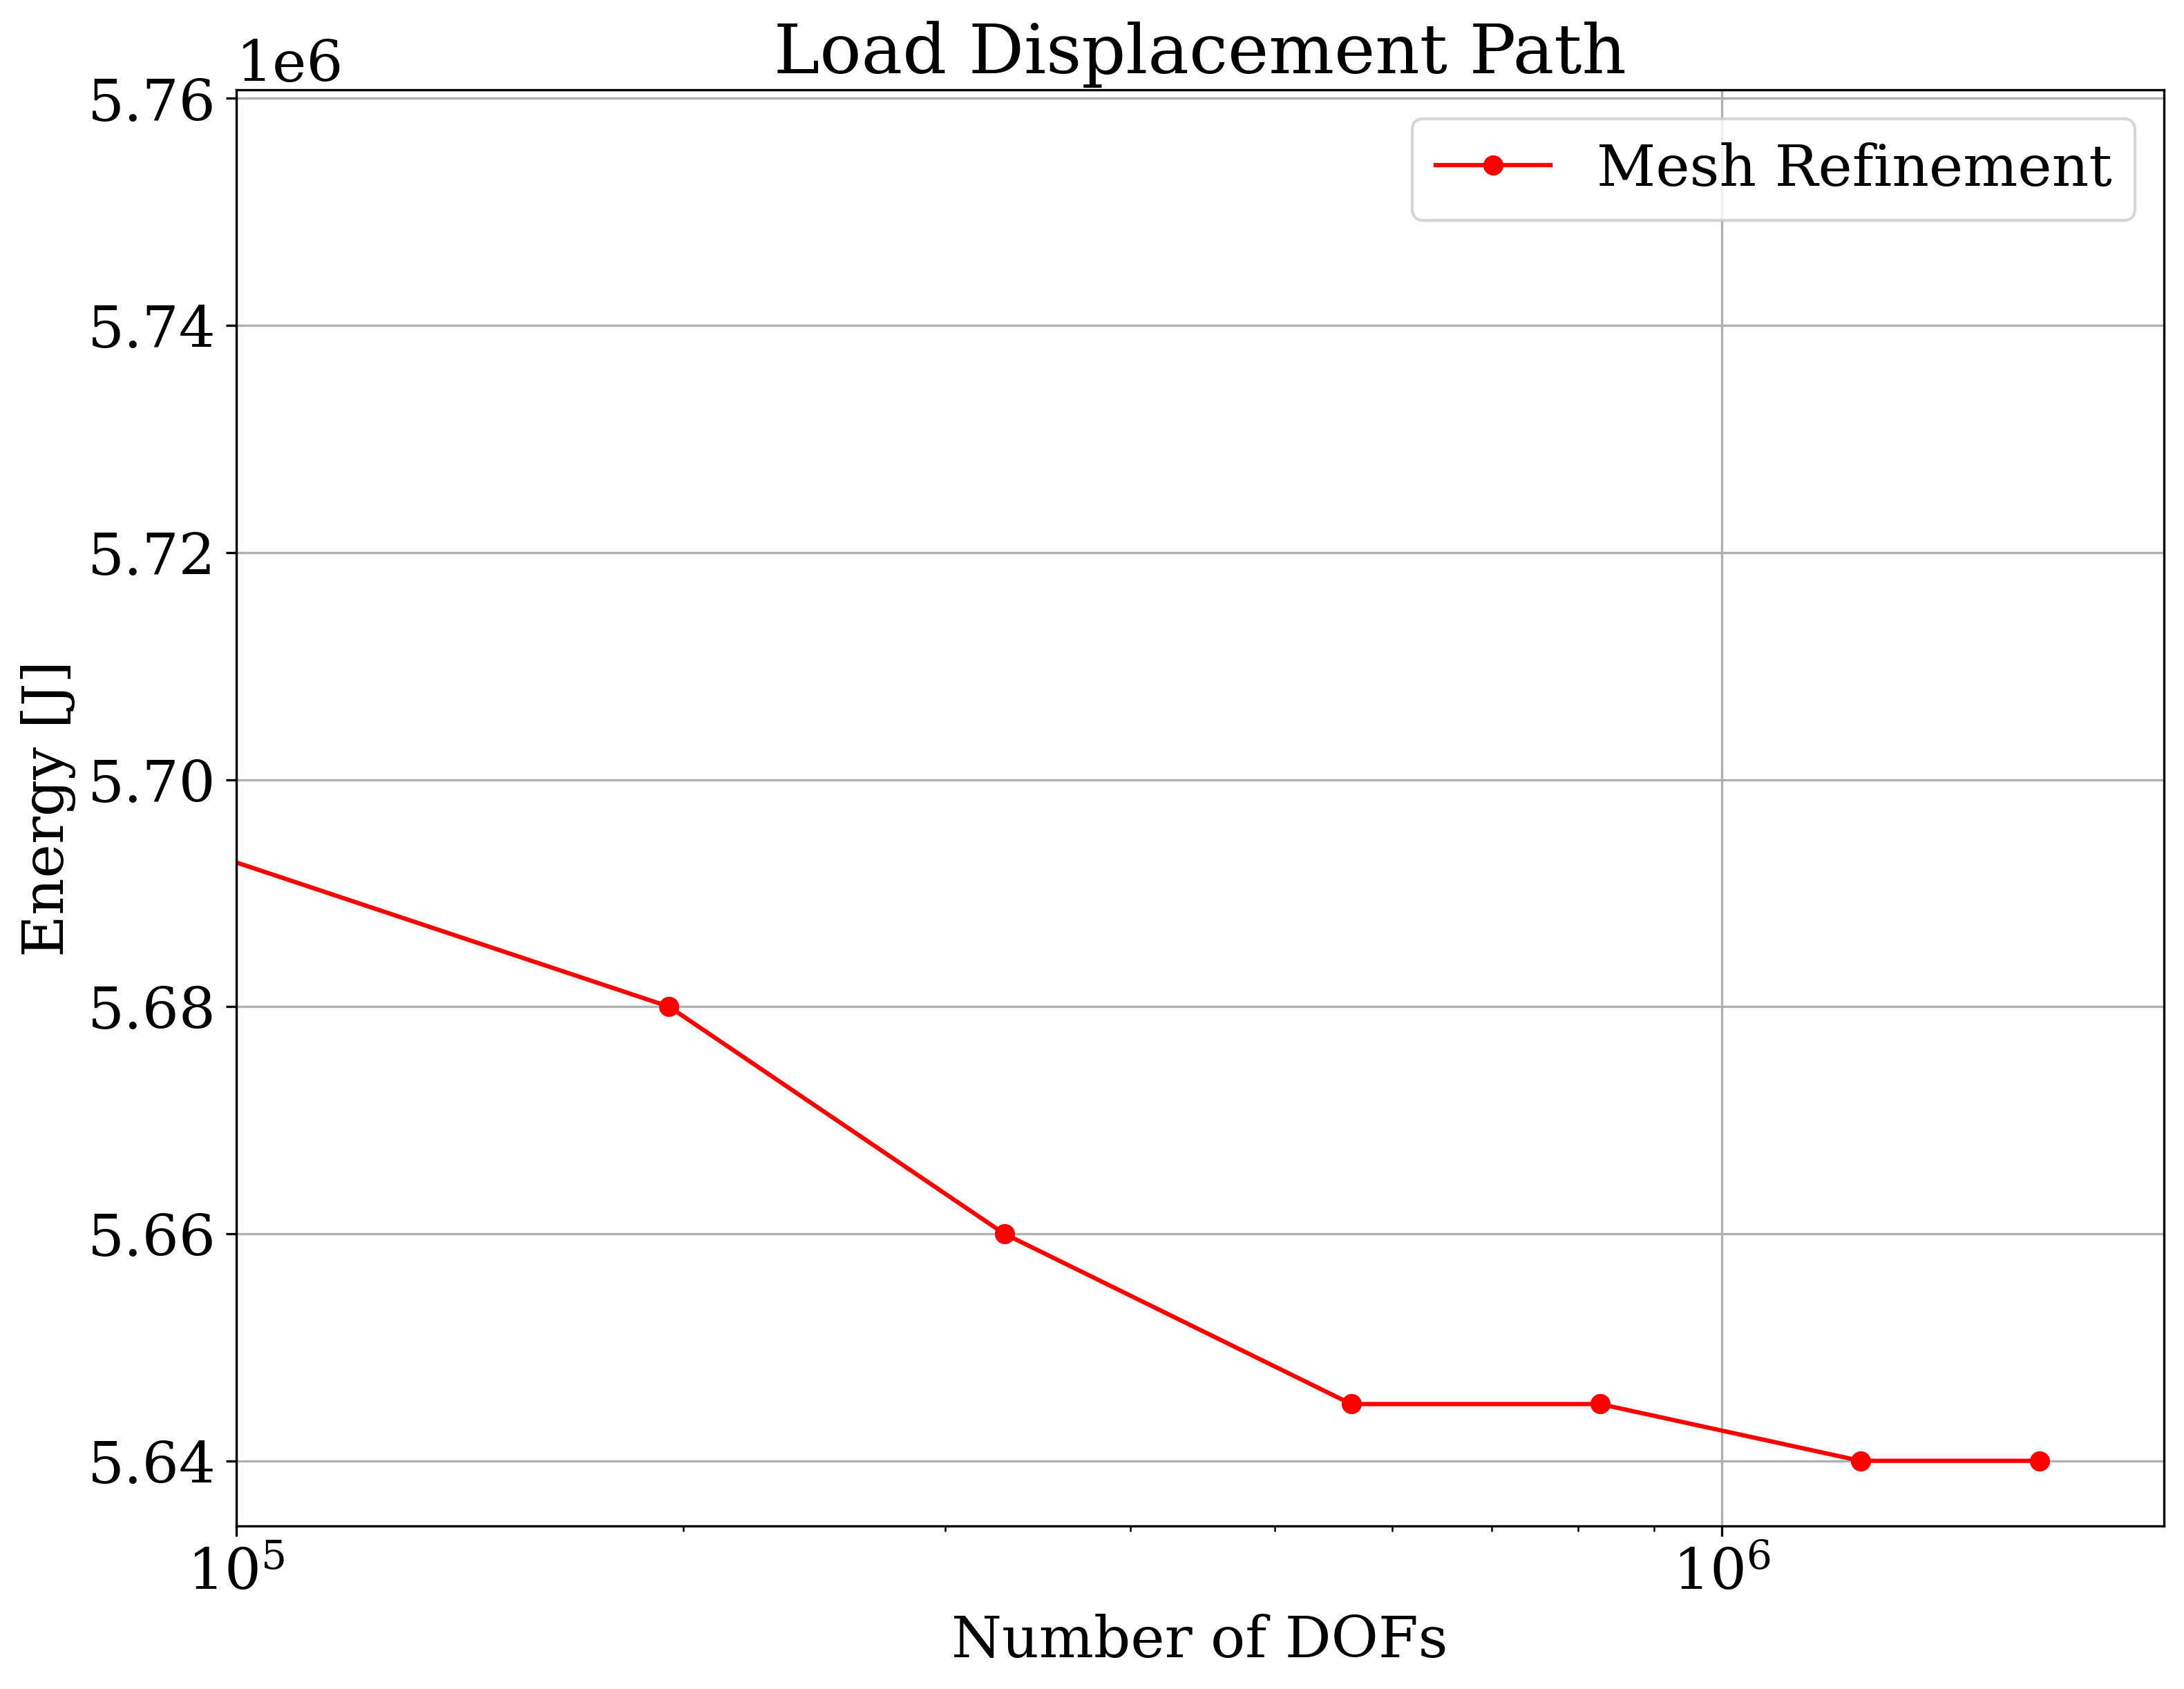

[115000.0, 55000.0, 40000.0, 20000.0, 5000.0, 5000.0, 0.0, 0.0]
[115000.0, 55000.0, 40000.0, 20000.0, 5000.0, 5000.0]


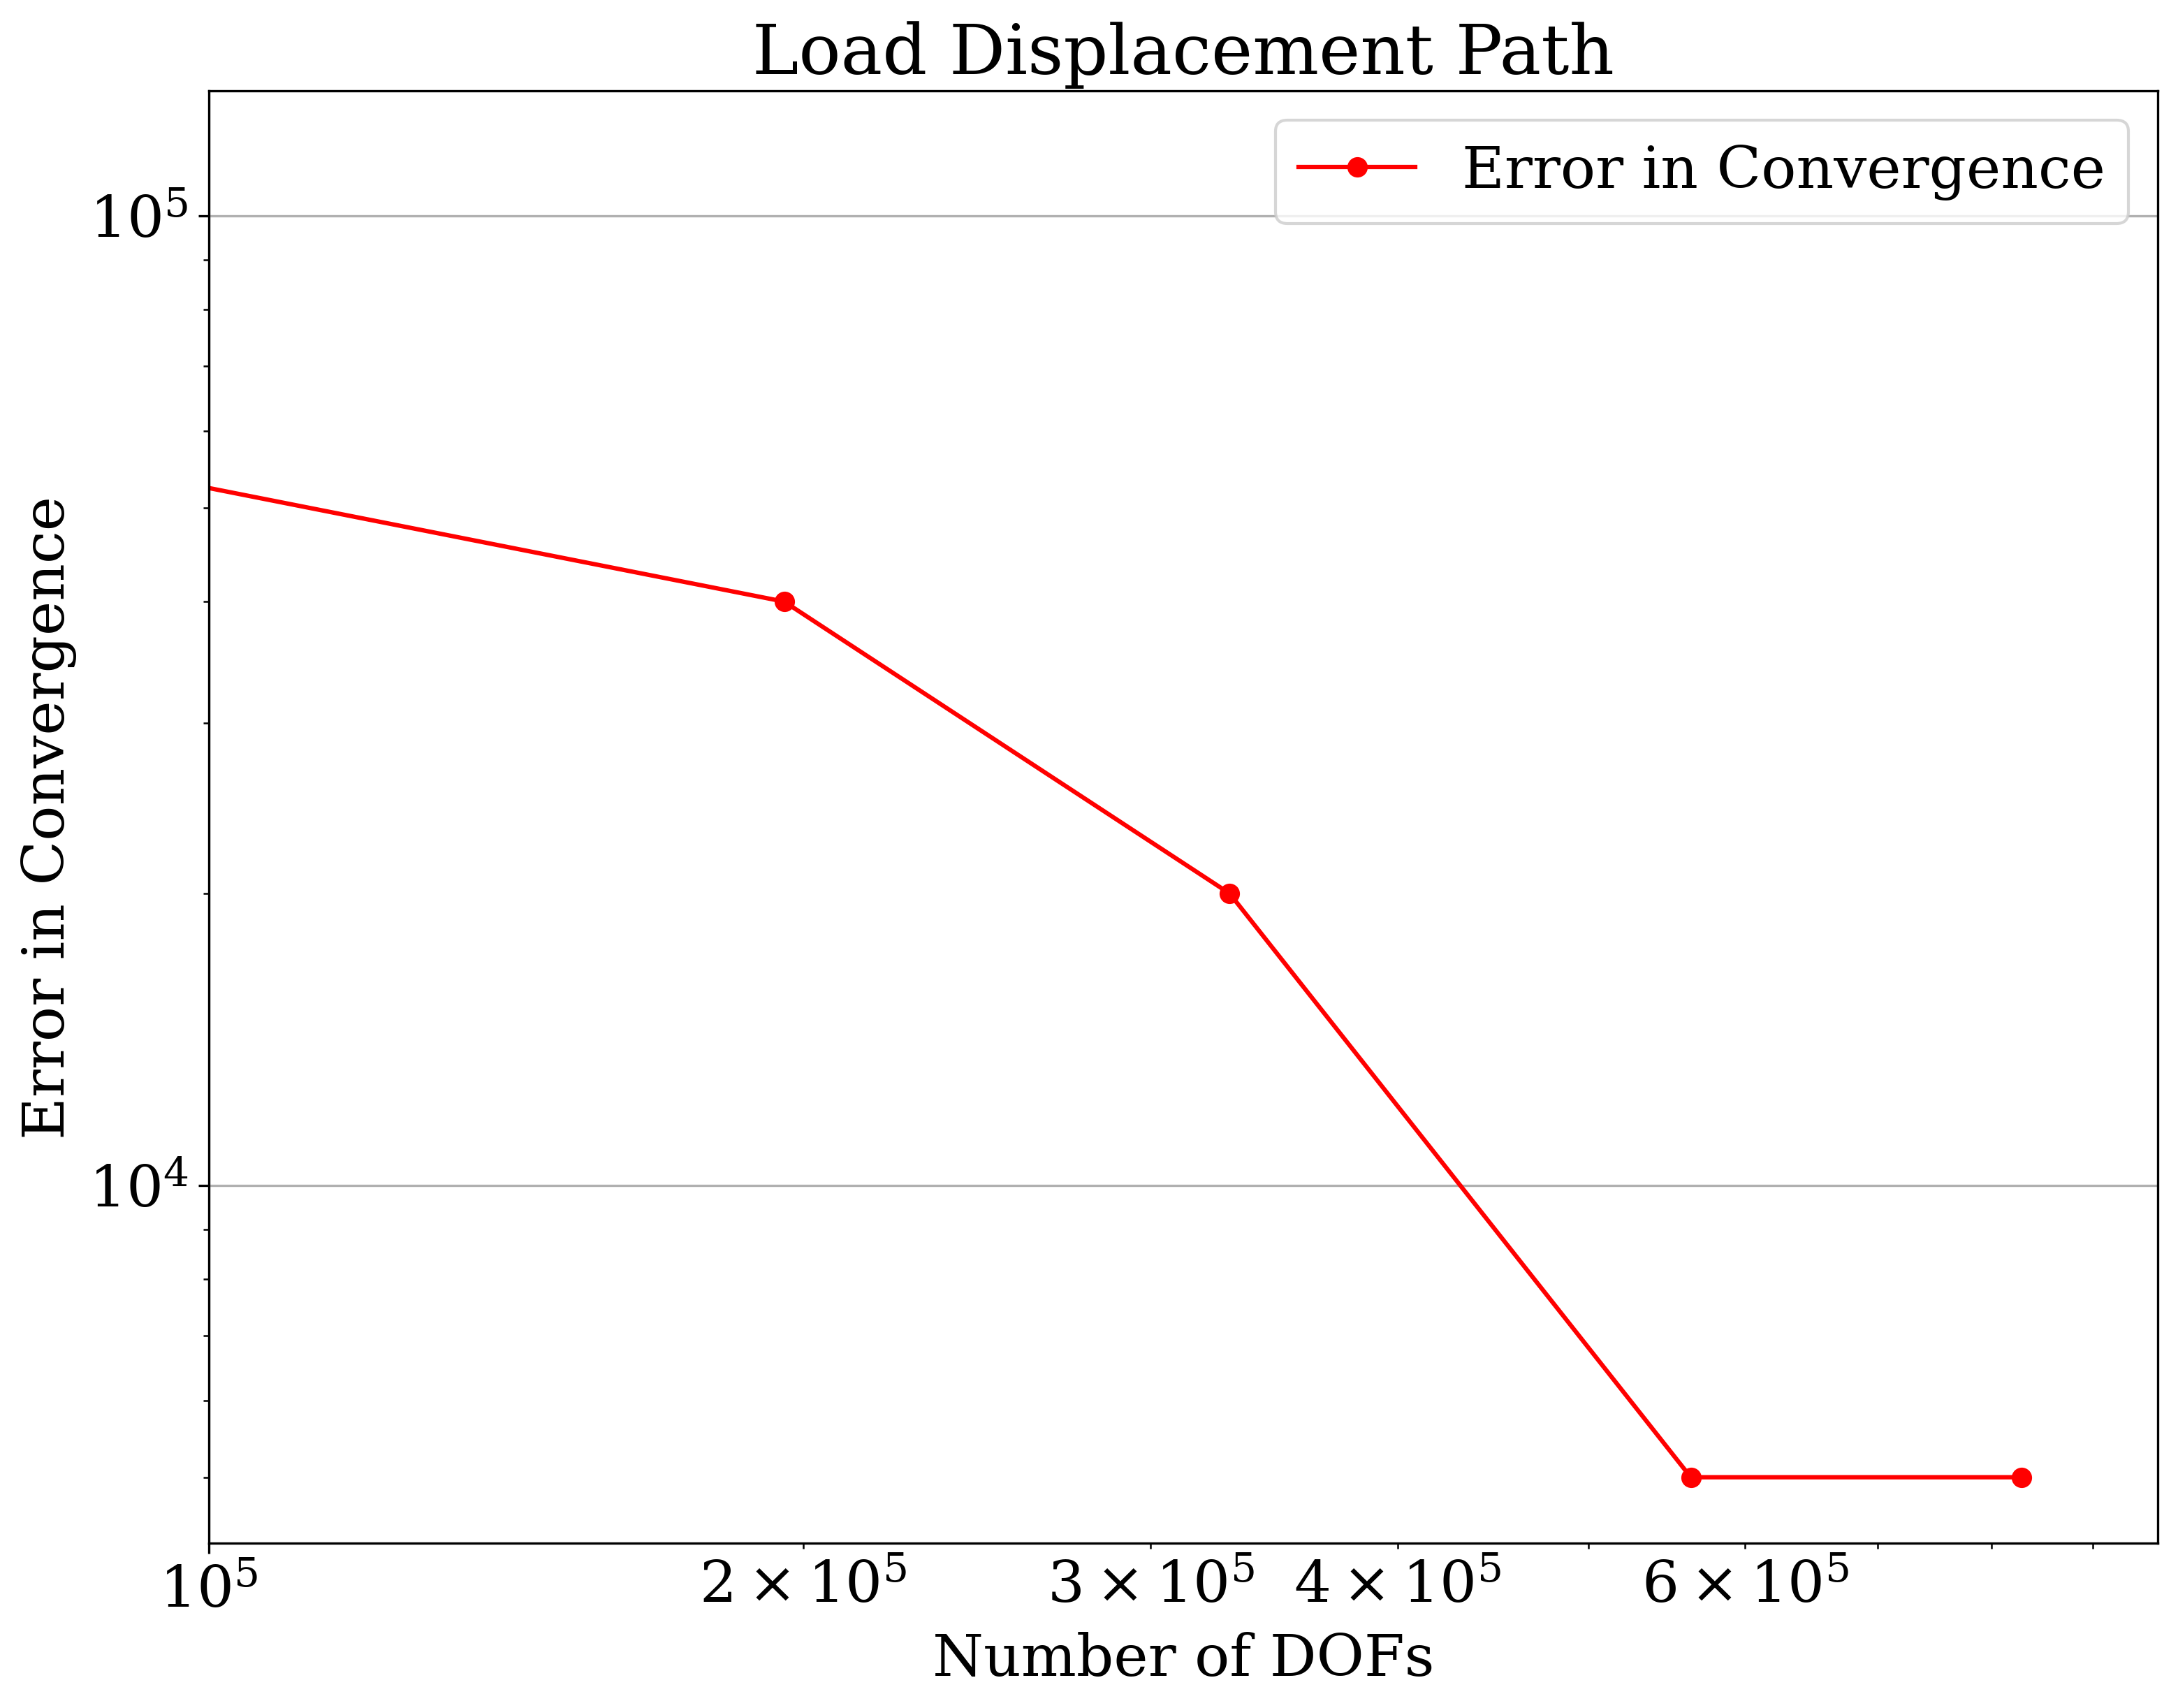

In [6]:
# NON-UNIFORM MESH REFINEMENT

# Extract relevant data from log file and save into other files
xvalues = [] # number of DOFs
yvalues = [] # values of energy
UFixX1Force = [] # force associated with applied displacement

list_log = ['log_meshSSFinal_20Progression', 'log_meshSSFinal_30Progression', 'log_meshSSFinal_40Progression', 'log_meshSSFinal_50Progression', 'log_meshSSFinal_60Progression', 'log_meshSSFinal_70Progression', 'log_meshSSFinal_80Progression', 'log_meshSSFinal_90Progression']
for log_name in list_log:
    !grep 'Total force:' {log_name} > tot_force
    !grep 'Force:' {log_name} > force
    !grep 'nb global dofs' {log_name} > dofs
    data_tot_force=pd.read_csv('tot_force',sep='\s+',header=None)
    data_force=pd.read_csv('force',sep='\s+',header=None)
    data_plot_y = data_force[4][2]
    data_dofs=pd.read_csv('dofs',sep='\s+',header=None)
    data_plot_x = data_dofs[15][0]
    prescribed_displacement = 1
    energy = data_plot_y * prescribed_displacement * 0.5

    xvalues.append(data_plot_x)
    yvalues.append(energy)
    UFixX1Force.append(data_plot_y)

print(xvalues)
print(yvalues) # something wrong with the energy values - transfinite curve on bottom of pile surface
print(UFixX1Force)

# create a figure and an axis   
fig, ax = plt.subplots()

# plot the data
ax.plot(xvalues, yvalues, 'ro-', label='Mesh Refinement')

# set axis to a logarithmic scale
ax.set_xscale('log')
#ax.set_yscale('log')

# set labels and title
ax.set(xlabel='Number of DOFs', ylabel='Energy [J]',
        title='Load Displacement Path')
# set the x-axis to start from 10^5
ax.set_xlim(left=100000)
#ax.axis(xmin=0)

# add legend and grid
ax.legend(loc='best')
ax.grid(True)

#show plot
plt.show()

# Plot error in convergence
index_of_final_log = len(list_log) - 1
reference_energy = None
for i, log_name in enumerate(list_log):
    if i == index_of_final_log:
        reference_energy = energy
difference_values = [energy - reference_energy for energy in yvalues]
print(difference_values)
non_zero_difference_values = [value for value in difference_values if value != 0]
print(non_zero_difference_values)

# create a figure and an axis   
fig, ax = plt.subplots()

# plot the data
ax.plot(xvalues[:len(non_zero_difference_values)], non_zero_difference_values, 'ro-', label='Error in Convergence')

# set axis to a logarithmic scale
ax.set_xscale('log')
ax.set_yscale('log')

# set labels and title
ax.set(xlabel='Number of DOFs', ylabel='Error in Convergence',
        title='Load Displacement Path')
# set the x-axis to start from 10^5
ax.set_xlim(left=100000)

# add legend and grid
ax.legend(loc='best')
ax.grid(True)

#show plot
plt.show()

# Plot should be linear however curves as you move down. The mesh is not being uniformly refined i.e. transfinite curves are 
# not applied to the thickness lines of the pile or the soil domain. Process repeated with transfinite curves now also applied
# to these lines. 


### Convergence Analysis - Uniform Mesh Refinement

[34971, 87489, 194379, 333492, 549054, 801570, 1213074, 1632597, 2255403, 2873880, 3806895]
[5825000.0, 5755000.0, 5705000.0, 5680000.0, 5665000.0, 5660000.0, 5650000.0, 5650000.0, 5645000.0, 5645000.0, 5645000.0]
[11650000.0, 11510000.0, 11410000.0, 11360000.0, 11330000.0, 11320000.0, 11300000.0, 11300000.0, 11290000.0, 11290000.0, 11290000.0]


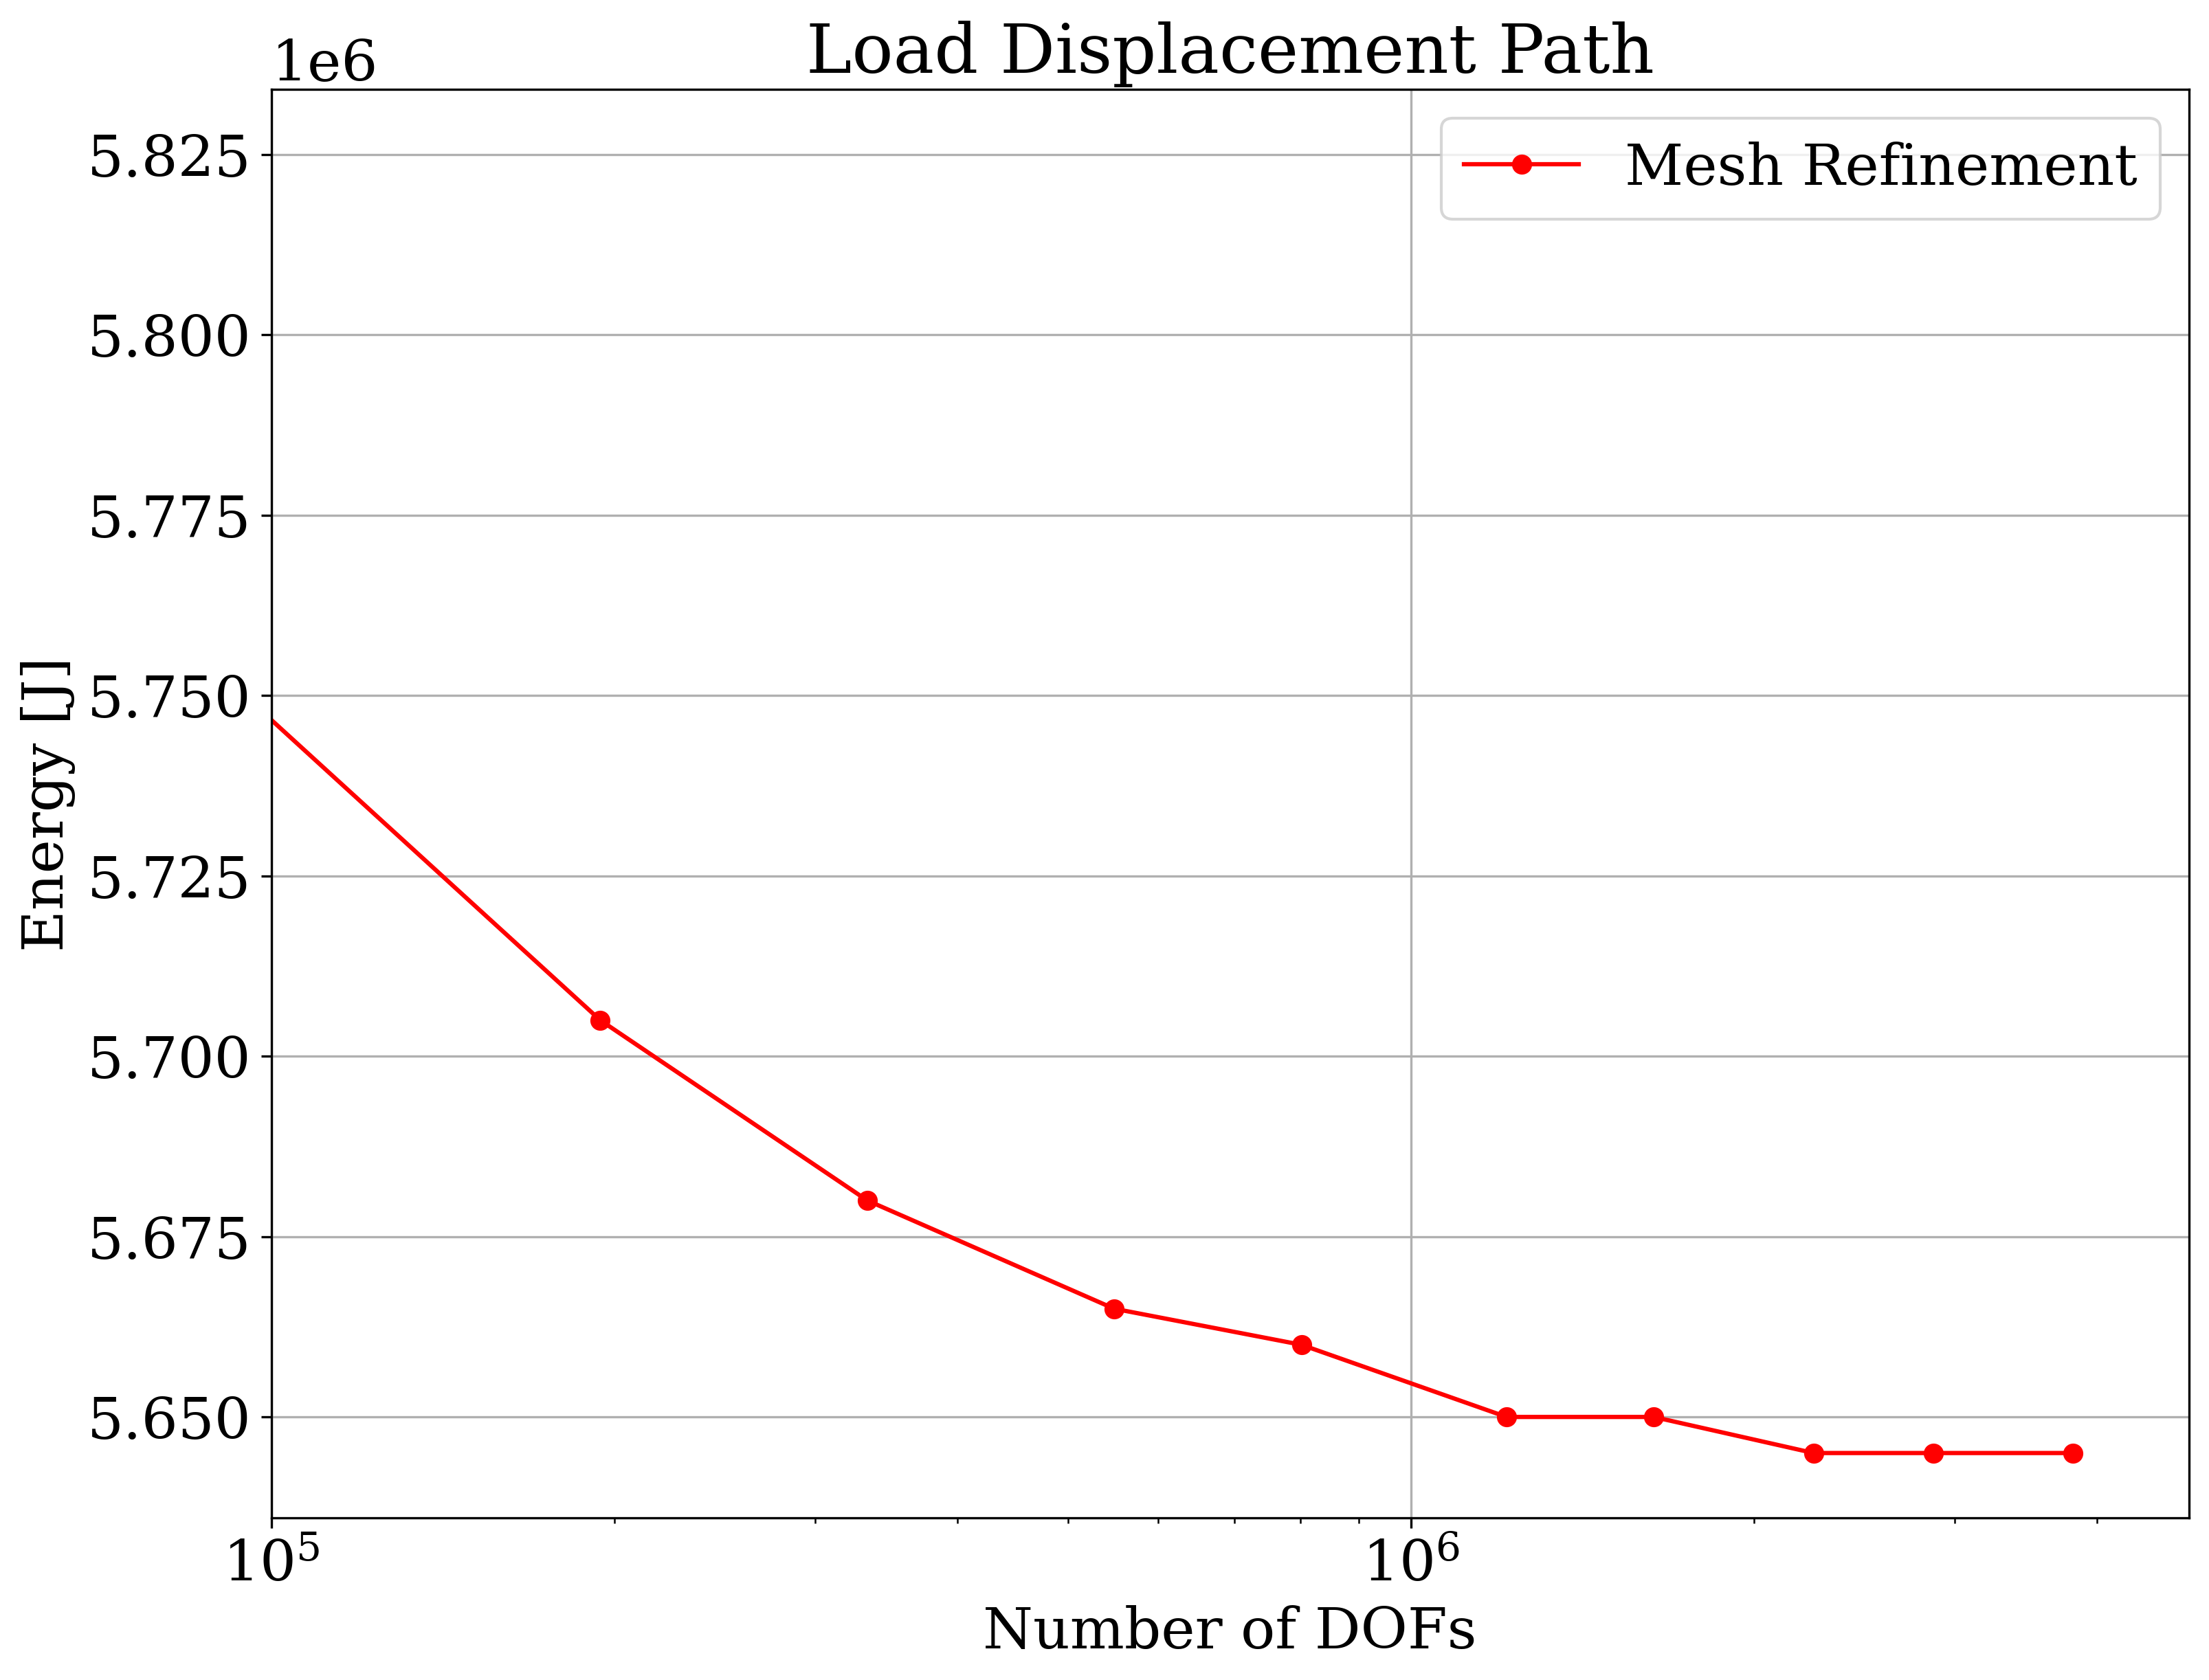

[180000.0, 110000.0, 60000.0, 35000.0, 20000.0, 15000.0, 5000.0, 5000.0, 0.0, 0.0, 0.0]
[180000.0, 110000.0, 60000.0, 35000.0, 20000.0, 15000.0, 5000.0, 5000.0]


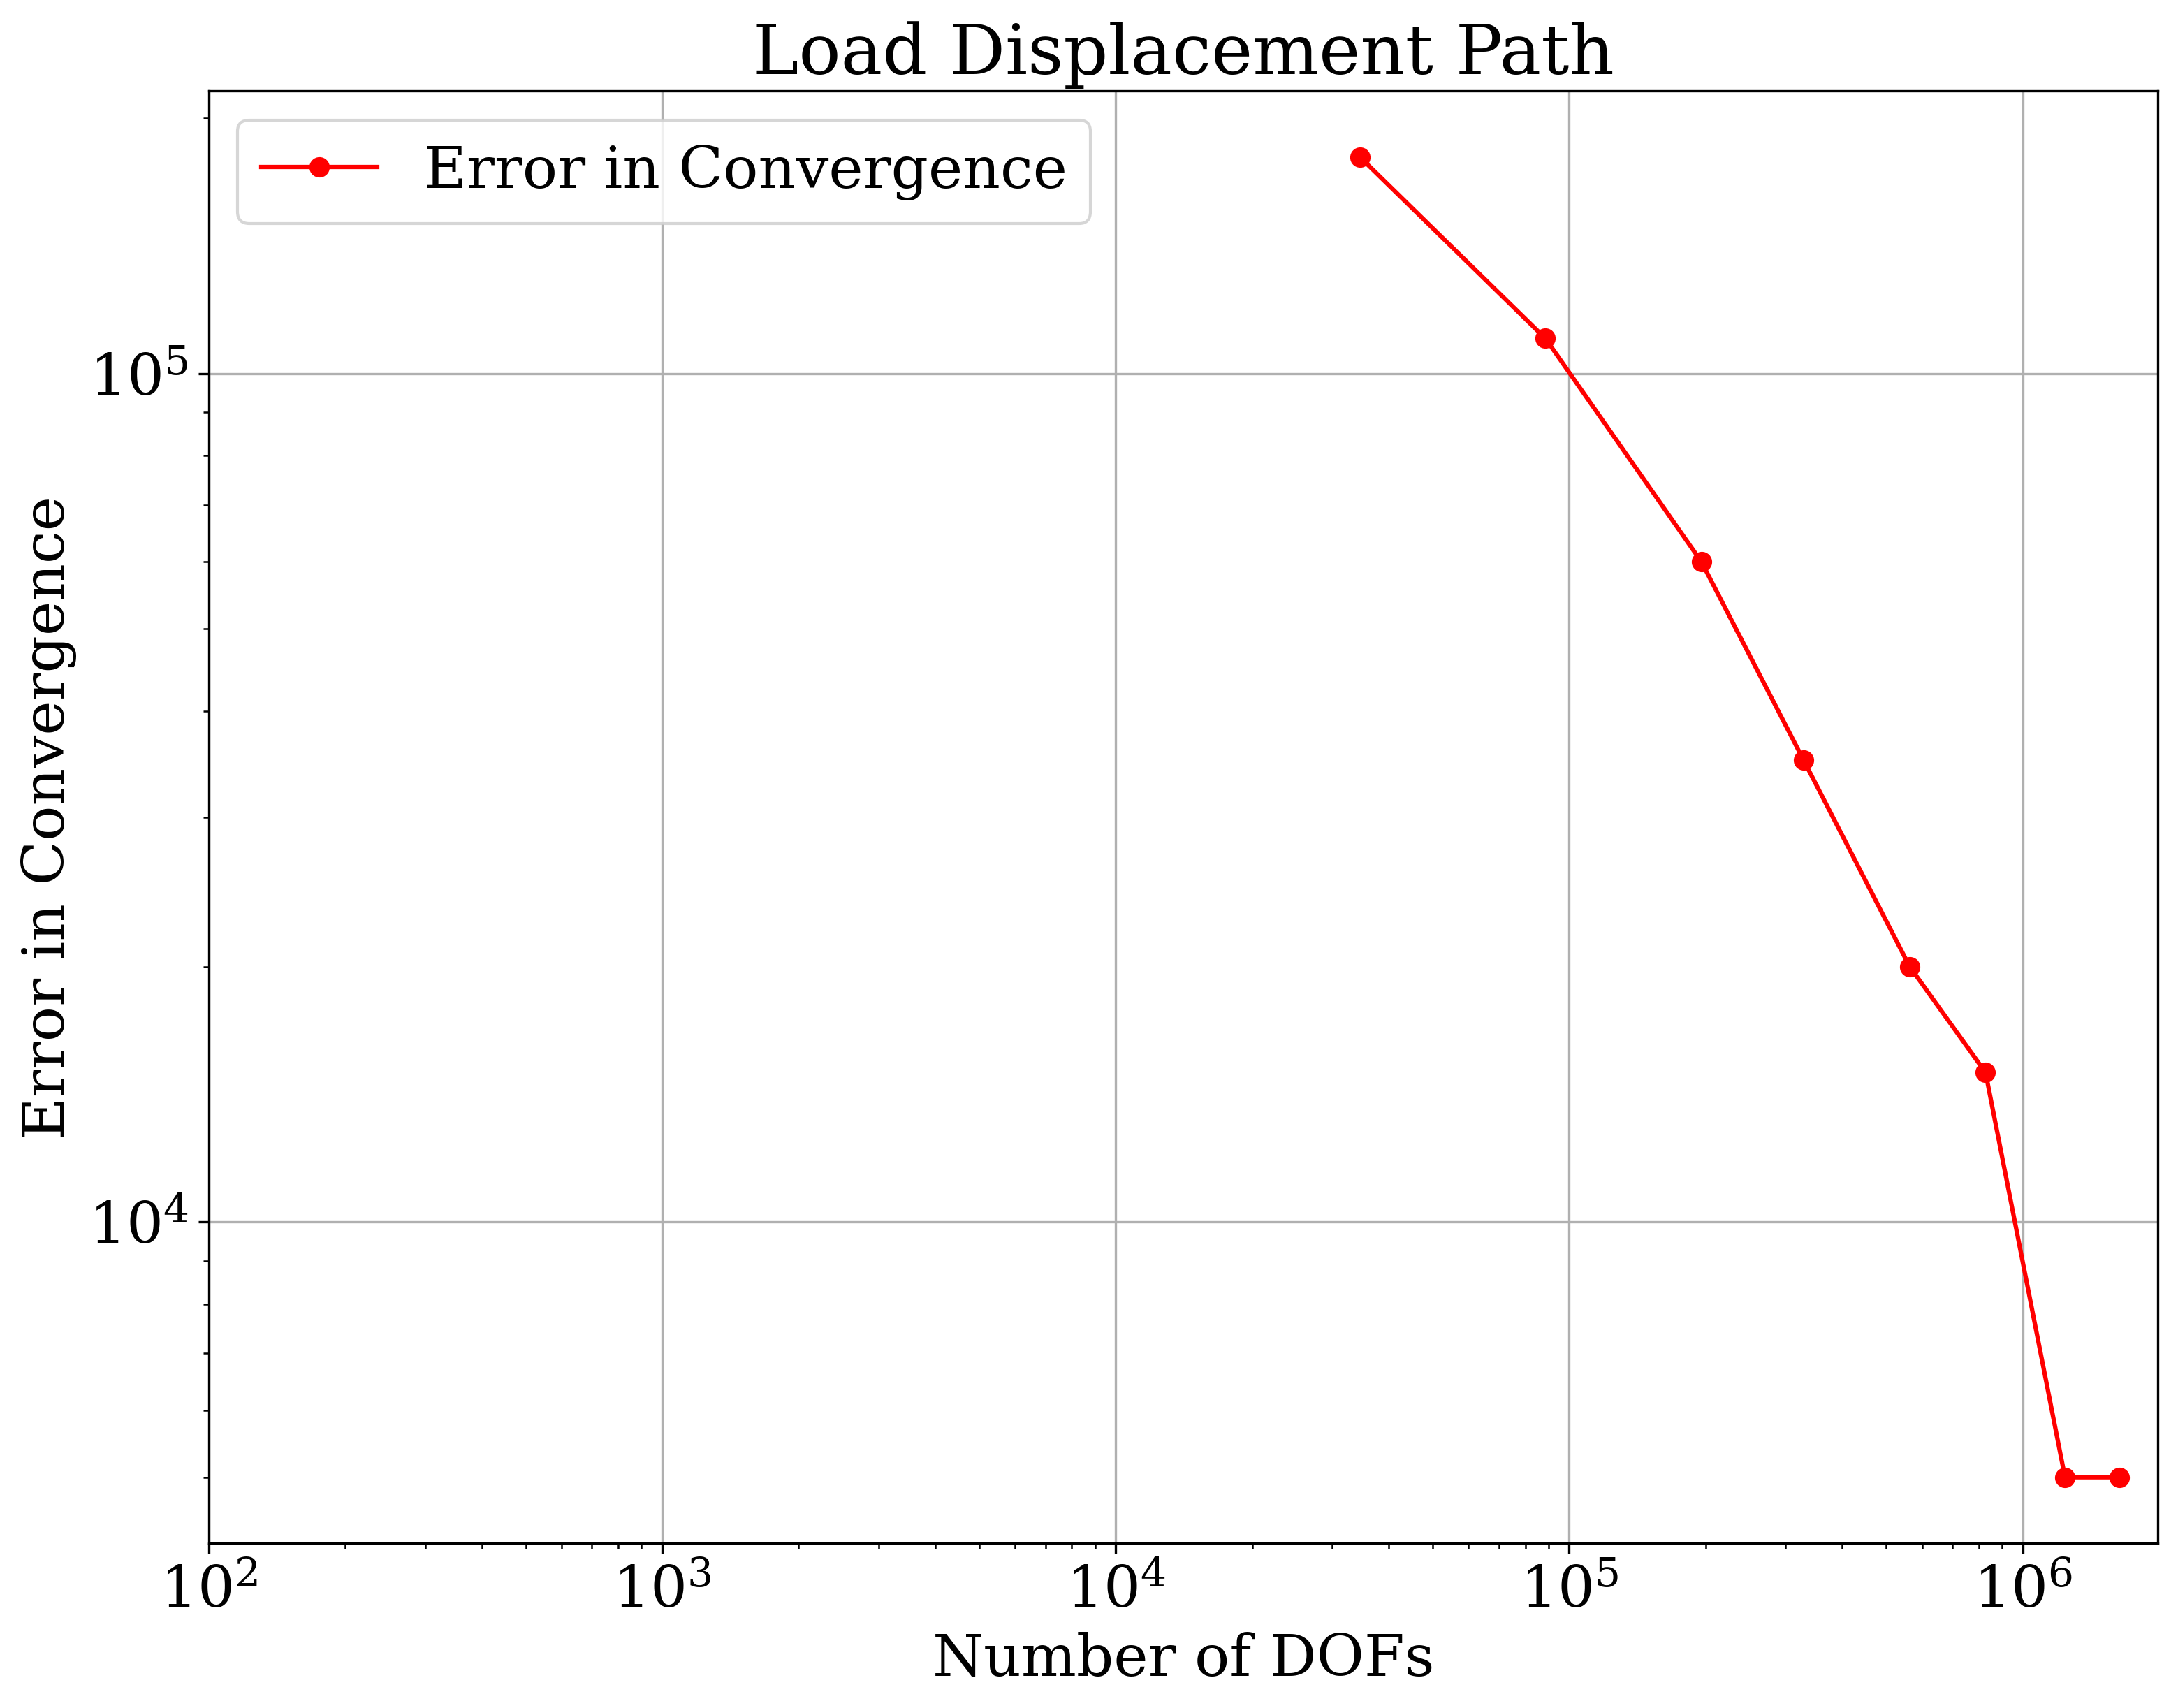

In [7]:
# UNIFORM MESH REFINEMENT
# CONVERGENCE ANALYSIS FOR REFINEMENT OF BOTH PILE AND SOIL DOMAIN

# Extract relevant data from log file and save into other files
xvalues_new = [] # number of DOFs
yvalues_new = [] # values of energy
UFixX1Force_new = [] # force associated with applied displacement

list_log2 = ['log_meshSSFinal_20Uniform', 'log_meshSSFinal_30Uniform', 'log_meshSSFinal_40Uniform', 'log_meshSSFinal_50Uniform', 'log_meshSSFinal_60Uniform', 'log_meshSSFinal_70Uniform', 'log_meshSSFinal_80Uniform', 'log_meshSSFinal_90Uniform', 'log_meshSSFinal_100Uniform', 'log_meshSSFinal_110Uniform', 'log_meshSSFinal_120Uniform']
for log_name in list_log2:
    !grep 'Total force:' {log_name} > tot_force
    !grep 'Force:' {log_name} > force
    !grep 'nb global dofs' {log_name} > dofs
    data_tot_force=pd.read_csv('tot_force',sep='\s+',header=None)
    data_force=pd.read_csv('force',sep='\s+',header=None)
    data_plot_y = data_force[4][2]
    data_dofs=pd.read_csv('dofs',sep='\s+',header=None)
    data_plot_x = data_dofs[15][0]
    prescribed_displacement = 1
    energy = data_plot_y * prescribed_displacement * 0.5

    xvalues_new.append(data_plot_x)
    yvalues_new.append(energy)
    UFixX1Force_new.append(data_plot_y)

print(xvalues_new)
print(yvalues_new)
print(UFixX1Force_new)

# create a figure and an axis   
fig, ax = plt.subplots()

# plot the data
ax.plot(xvalues_new, yvalues_new, 'ro-', label='Mesh Refinement')

# set axis to a logarithmic scale
ax.set_xscale('log')
#ax.set_yscale('log')

# set labels and title
ax.set(xlabel='Number of DOFs', ylabel='Energy [J]',
        title='Load Displacement Path')
# set the x-axis to start from 10^5
ax.set_xlim(left=100000)
#ax.axis(xmin=0)

# add legend and grid
ax.legend(loc='best')
ax.grid(True)

#show plot
plt.show()

# Plot error in convergence
index_of_final_log = len(list_log2) - 1
reference_energy = None
for i, log_name in enumerate(list_log2):
    if i == index_of_final_log:
        reference_energy = energy
difference_values_new = [energy - reference_energy for energy in yvalues_new]
print(difference_values_new)
non_zero_difference_values_new = [value for value in difference_values_new if value != 0]
print(non_zero_difference_values_new)

# create a figure and an axis   
fig, ax = plt.subplots()

# plot the data
ax.plot(xvalues[:len(non_zero_difference_values_new)], non_zero_difference_values_new, 'ro-', label='Error in Convergence')

# set axis to a logarithmic scale
ax.set_xscale('log')
ax.set_yscale('log')

# set labels and title
ax.set(xlabel='Number of DOFs', ylabel='Error in Convergence',
        title='Load Displacement Path')
# set the x-axis to start from 10^4
ax.set_xlim(left=100)

# add legend and grid
ax.legend(loc='best')
ax.grid(True)

#show plot
plt.show()

# Lucasz says this plot is sufficient.

In [8]:
# Showing results of vtks
def show_results(params):
    out_to_vtk = !ls -c1 {params.show_file}*vtk
    last_file=out_to_vtk[0]

    mesh = pv.read(last_file[:-3] + "vtk")
    if params.warp_field:
        mesh = mesh.warp_by_vector(vectors=params.warp_field, factor=params.warp_factor)

    if params.show_edges:
        mesh=mesh.shrink(0.95)
    
    jupyter_backend='ipygany'
    cmap = "turbo"

    p = pv.Plotter(notebook=True)
    p.add_mesh(mesh, scalars=params.show_field, component=None, smooth_shading=True, cmap=cmap)
    p.camera_position = "xy"
    
    p.enable_parallel_projection()
    p.enable_image_style()
    
    p.show(jupyter_backend=jupyter_backend)

params.show_file = "out_elastic"
params.show_field = "STRESS"
params.warp_field = "U"     # warp with displacement
params.warp_factor = 0
params.show_edges = True
show_results(params)

AppLayout(children=(VBox(children=(HTML(value='<h3>STRESS</h3>'), Dropdown(description='Colormap:', options=((…

### Output Parameters

# 